<a href="https://colab.research.google.com/github/solrepresa/ML_Datos_Deportivos/blob/master/LM_Deporte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Datos Deportivos

## 0) Configurar el entorno

**¡Importantísimo!** 

Instalar JAVA en Google Colab. El siguiente código instala Apache Spark 2.4.4, Java 8 y Findspark , una biblioteca que facilita a Python encontrar Spark.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [9]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

! java -version

openjdk version "11.0.6" 2020-01-14
OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)


In [10]:
# Cargamos librerias
!pip install --upgrade pyspark

from pyspark import SparkConf, SparkContext
from pyspark.sql import HiveContext
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
#from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.context import SparkContext
from pyspark.sql.functions import col
from pyspark.sql.session import SparkSession


import pandas as pd
import numpy as np

Requirement already up-to-date: pyspark in /usr/local/lib/python3.6/dist-packages (2.4.5)


In [0]:
import findspark
findspark.init()

Creamos un contexto y sesión para Spark. Luego lo vamos a cerrar al final del código.

In [12]:
# Configuración de entorno
confspark = SparkConf()
confspark.set("spark.master", "local") # 2 hilos ¿como se dice en español?
confspark.set("spark.app.name", "AppPruebaMBDD")

In [0]:
# Inicialización
sc = SparkContext(conf = confspark)
sqlcx = HiveContext(sc)

---------------------------------------------------------------------------
## 1) Preparación y descripción de los datos

## 1.1 Cargar datos

Para la carga de datos utilizamos Pandas:

In [0]:
# Abrir conjunto de datos
url = "http://www.football-data.co.uk/mmz4281/1718/SP1.csv"
df = pd.read_csv(url)
data = sqlcx.createDataFrame(df)

In [15]:
type(data)

pyspark.sql.dataframe.DataFrame

In [16]:
data.show(10) # Para visualizar las primeras 10 filas
#data.printSchema() # Nos muestra en detalle las clases de nuestras variables

+---+--------+----------+-----------+----+----+---+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+----+--------+--------+--------+--------+----+-----+-------+-------+-------+-------+----+----+----+
|Div|    Date|  HomeTeam|   AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR| HS| AS|HST|AST| HF| AF| HC| AC| HY| AY| HR| AR|B365H|B365D|B365A| BWH| BWD| BWA| IWH| IWD| IWA| LBH| LBD| LBA|  PSH| PSD| PSA| WHH| WHD| WHA| VCH| VCD| VCA|Bb1X2|BbMxH|BbAvH|BbMxD|BbAvD|BbMxA|BbAvA|BbOU|BbMx>2.5|BbAv>2.5|BbMx<2.5|BbAv<2.5|BbAH|BbAHh|BbMxAHH|BbAvAHH|BbMxAHA|BbAvAHA|PSCH|PSCD|PSCA|
+---+--------+----------+-----------+----+----+---+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+----+---

Seleccionamos las variables para trabajar:

In [0]:
#data.columns[2:22]
data = data.select(data.columns[2:22]) # Nos quedamos con las columnas q nos interesan

Información sobre los datos:

* *HomeTeam* es el equipo local. *AwayTeam* es el equipo visitante.

* *HY*, *HR*, *AY*, *AR* son el número de tarjetas amarillas y rojas para los equipos locales y visitantes en cada partido.

### 1.2 Limpieza de NAN y NULL


Limpieza de NAN y NULL: ¿Hay NAN o null?

In [18]:
import pyspark.sql.functions as F

data.select([F.count(F.when(F.isnan(c),c)).alias(c) for c in data.columns]).show() #Numero de NAN
data.select([F.count(F.when(F.isnull(c),c)).alias(c) for c in data.columns]).show() #Numero de Null

+--------+--------+----+----+---+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+
|HomeTeam|AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR| HS| AS|HST|AST| HF| AF| HC| AC| HY| AY| HR| AR|
+--------+--------+----+----+---+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+
|       0|       0|   0|   0|  0|   0|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
+--------+--------+----+----+---+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+

+--------+--------+----+----+---+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+
|HomeTeam|AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR| HS| AS|HST|AST| HF| AF| HC| AC| HY| AY| HR| AR|
+--------+--------+----+----+---+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+
|       0|       0|   0|   0|  0|   0|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
+--------+--------+----+----+---+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+



### 1.3 Parámetros descriptivos
Previo a obtener la descripción estadística de los datos eliminamos las filas repetidas, esto lo hacemos con la función **distinct()**. Los parámetros estadísticos los podemos ver con la función **describe()**.

In [19]:
data = data.distinct() # Por si hay datos duplicados
data.describe().show() # Para ver estadísticos descriptivos

+-------+----------+----------+------------------+------------------+----+------------------+------------------+----+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-------------------+
|summary|  HomeTeam|  AwayTeam|              FTHG|              FTAG| FTR|              HTHG|              HTAG| HTR|                HS|                AS|               HST|              AST|               HF|                AF|               HC|                AC|                HY|                AY|                 HR|                 AR|
+-------+----------+----------+------------------+------------------+----+------------------+------------------+----+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------

Se propone como actividad transformar variables numéricas a categóricas.

In [0]:
# Faltas del equipo local
data_transf = data.withColumn("CategoriaFaltas", F.when(F.col("HF").between(10,20), "MEDIA").when(F.col("HF")<10, "POCAS").otherwise("MUCHAS"))

# Total de tarjetas en el partido
data_transf = data_transf.withColumn("TotalTarjeta", data.HY + data.HR + data.AY + data.AR)

In [22]:
data_transf.show(5)

+-----------+-----------+----+----+---+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---------------+------------+
|   HomeTeam|   AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR| HS| AS|HST|AST| HF| AF| HC| AC| HY| AY| HR| AR|CategoriaFaltas|TotalTarjeta|
+-----------+-----------+----+----+---+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---------------+------------+
|    Espanol|      Betis|   1|   0|  H|   0|   0|  D| 10|  9|  4|  4| 10| 17|  5|  3|  2|  5|  0|  0|          MEDIA|           7|
|    Leganes|     Malaga|   2|   0|  H|   0|   0|  D| 10|  4|  3|  1| 11| 14|  6|  1|  1|  1|  0|  0|          MEDIA|           2|
|    Sevilla|Real Madrid|   3|   2|  H|   2|   0|  H| 14| 14|  6|  4| 21|  9|  2|  3|  3|  1|  0|  0|         MUCHAS|           4|
|  Barcelona|   Sociedad|   1|   0|  H|   0|   0|  D| 12| 13|  4|  2| 13| 13|  3|  8|  3|  2|  0|  0|          MEDIA|           5|
|Real Madrid|      Betis|   0|   1|  A|   0|   0|  D| 27| 12|  7|  4| 13| 11| 12|  

In [0]:
#Normalizacion de las variables (no es necesario porq los métodos son no parametricos)

#from pyspark.sql.function import udf
#from pyspark.sql.types import FloatType

## Definimos una funcion para normalizar los valores
#def normalize(valor, media, desviacion):
#  return(valor - media)/desviacion

## Registramos la funcion como funcion de usuario
# normalize_udf = udf(normalize, FloatTipe())

### 1.4 Convertir datos *string* 
Antes de aplicar el modelo necesitamos convertir las variables de tipo texto. ¿Cuáles son las variables tipo string que tenemos?

In [23]:
# Seleccionamos columnas de tipo string
catcolums = [item[0] for item in data_transf.dtypes if item[1].startswith('string')] 
print(catcolums)

['HomeTeam', 'AwayTeam', 'FTR', 'HTR', 'CategoriaFaltas']


Convertir las variables texto en categóricas llevan varios pasos:

1.   Definimos las variables de ingreso al modelo con **StringIndexer()**
2.   Entrenamos el modelo con **fit**
3.   Transformamos nuestros datos con **transform**


La función **StringIndexer()** convierte una columna *string* en una columna *index* que es tratada con una variable categorica por spark. Los indices comienzan en 0 y avanzan por la frecuencia con la que aparecen.

Luego, con la función **OneHotEncoder()** convertimos la variable del tipo categórico en dummy.

Veamos una forma rápida de hacer todo esto:

In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

all_stages = [StringIndexer(inputCol=c, outputCol='idx_' + c) for c in catcolums] + [OneHotEncoder(inputCol='idx_' + c, outputCol='ohe_' + c) for c in catcolums]

data_new = Pipeline(stages = all_stages).fit(data_transf).transform(data_transf) #de lista a dataFrame

#data_new.show(3)

Ya teniendo todos los datos como números, procedemos a armar el FEATURES.


Para crear la columna FEATURES en utilizamos la función **VectorAssembler()**. Primero, creamos el modelo que nos permite transformar nuestros datos de entrada en una única columna y luego transformamos nuestros datos con la función **transform()**. Con la función **drop()** quitamos las columnas que no nos van a servir:

In [0]:
output = VectorAssembler(inputCols=['ohe_HomeTeam', 'ohe_AwayTeam', 'ohe_FTR',  'ohe_HTR', 'ohe_CategoriaFaltas',
                                       'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
                                       'AC', 'HY', 'AY', 'HR', 'AR'], 
                            outputCol='featuresCol').transform(data_new).drop('HomeTeam', 'HTR','AwayTeam', 'FTR','CategoriaFaltas',
                                                                              'idx_HomeTeam', 'idx_AwayTeam', 'idx_FTR', 'idx_HTR',
                                                                              'idx_CategoriaFaltas')

#output.show(truncate=False)

### 1.5 Crear set de entrenamiento y de prueba

Antes de continuar, dividimos nuestros datos en un set de entrenamiento (80%) y otro de prueba (20%):

In [0]:
(trainingData, testData) = output.randomSplit([0.8, 0.2], seed = 132)

--------------------------------------------------------------------------------

## 2) Implementación y análisis de algún modelo de clasificación

### 2.1) Modelo de **Regresión logística multinomial**
Utilizamos la función **LogisticRegression()** para crear el modelo. El parámetro *maxIter* determina el número de iteraciones. Luego con **fit()** lo entrenamos.


In [0]:
from pyspark.ml.classification import LogisticRegression

# Definimos el modelo > Regresión logística multinomial
lr = LogisticRegression(featuresCol = 'featuresCol', labelCol = 'TotalTarjeta', maxIter=10).fit(trainingData)

Para obtener los parámetros del modelo:

In [0]:
## Parámetros del modelo de Regresión Logística Multinomial
# print("Coeficientes: \n" + str(lr.coefficientMatrix))
# print("Intercepcion: " + str(lr.interceptVector))


Más información del modelo se obteniene con la función **summary()**

In [0]:
trainingSummary = lr.summary

In [0]:
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)


In [0]:
# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

### 2.2) Evaluamos el ajuste del modelo

In [33]:
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.6559485530546624
FPR: 0.052519567434777106
TPR: 0.6559485530546625
F-measure: 0.6543303997555765
Precision: 0.6808330474737649
Recall: 0.6559485530546625


-------------------------------------------------------------------------------
## 3) Implementación y análisis de algún modelo de regresión

### 3.1) Modelo **Random Forest**

Creamos el modelo de regresión Random Forest con la función **RandomForestRegressor()**:


In [0]:
# Definimos el modelo > Random Forest
rf = RandomForestRegressor(featuresCol = 'featuresCol', labelCol = 'TotalTarjeta', numTrees=100, seed= 123).fit(trainingData)

Finalmente, generamos las predicciones del modelo con la función **transform()**. 

In [0]:
predictions = rf.transform(testData)

### 3.2) Evaluamos el modelo

Para evaluar el modelo confeccionamos una serie de parámetros:

In [39]:
eval = RegressionEvaluator(labelCol = 'TotalTarjeta', predictionCol="prediction", metricName="rmse")

print("Modelo RF sin CV")
# Root Mean Square Error
rmse = eval.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data: %.3f" % rmse)

# Mean Square Error
mse = eval.evaluate(predictions, {eval.metricName: "mse"})
print("Mean Square Error (MSE) on test data: %.3f" % mse)

# Mean Absolute Error
mae = eval.evaluate(predictions, {eval.metricName: "mae"})
print("Mean Absolute Error (MAE) on test data: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval.evaluate(predictions, {eval.metricName: "r2"})
print("R Squared (R2) on test data: %.3f" %r2)

Modelo RF sin CV
Root Mean Squared Error (RMSE) on test data: 1.029
Mean Square Error (MSE) on test data: 1.058
Mean Absolute Error (MAE) on test data: 0.708
R Squared (R2) on test data: 0.863


### 3.3) Gráficamos las predicciones. 

Para ello es necesario convertir los datos del formato de Spark a Pandas con la función **toPandas()**. Para la gráfica utilizamos la librería *matplotlib*:

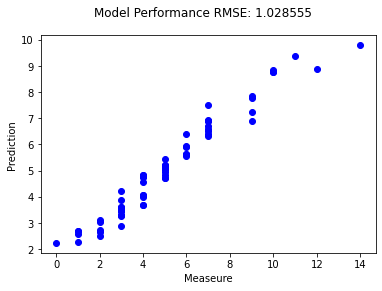

In [42]:
rfResult = predictions.toPandas()
#rfResult.head()

import matplotlib.pyplot as plt
plt.plot(rfResult.TotalTarjeta, rfResult.prediction, 'bo')
plt.xlabel('Measeure')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

-----------------------------------------------------------------------------
## 4) Webs consultadas
¡Gracias a la comunidad que construye conocimiento y lo pone a disposición!

* Este sitio me resultó de muchísima utilidad: https://mingchen0919.github.io/learning-apache-spark/ 
* https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa